# Stereo Vision: Bản đồ độ chênh lệch (disparity map), Tái tạo 3D và Hình học Epipolar
Notebook này minh họa cách tính toán bản đồ độ chênh lệch, tái tạo đám mây điểm 3D và ước lượng ma trận cơ bản để vẽ các đường epipolar sử dụng hình ảnh stereo.

## Bước 1: Nhập các thư viện cần thiết
Chúng ta sẽ sử dụng OpenCV để xử lý hình ảnh và NumPy để tính toán số học.

In [26]:
# Import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Bước 2: Tải hình ảnh Stereo
Tải hình ảnh bên trái và bên phải cho tầm nhìn stereo.

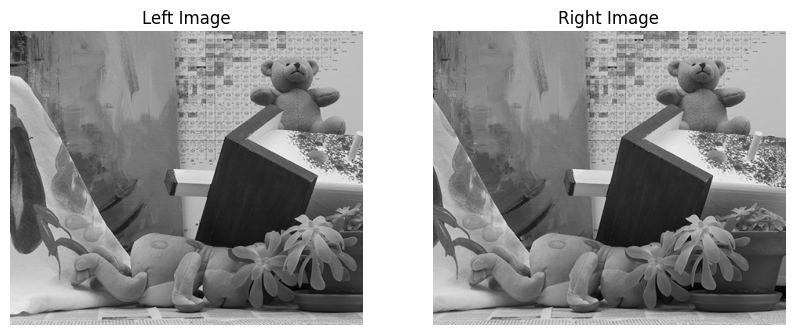

In [27]:
# Load stereo images
left_image = cv2.imread('input/left.png', cv2.IMREAD_GRAYSCALE)
right_image = cv2.imread('input/right.png', cv2.IMREAD_GRAYSCALE)

# Display the images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(left_image, cmap='gray')
plt.title('Left Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(right_image, cmap='gray')
plt.title('Right Image')
plt.axis('off')
plt.show()

## Bước 3: Tính toán Bản đồ Độ chênh lệch
Sử dụng Stereo Block Matching (BM) hoặc Stereo Global Block Matching (SGBM) để tính toán bản đồ độ chênh lệch.

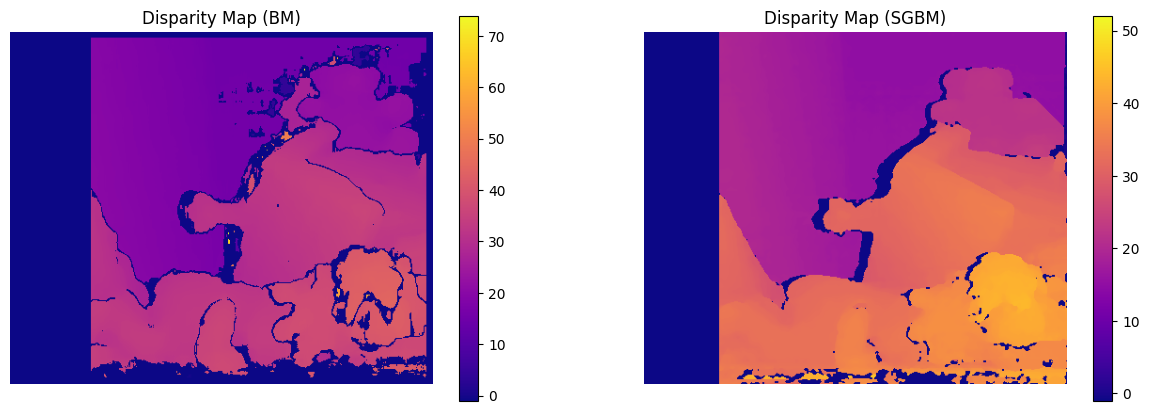

Disparity maps saved to output/disparity_map_bm.png and output/disparity_map_sgbm.png


In [28]:
# Compute disparity map using StereoBM
stereo_bm = cv2.StereoBM_create(numDisparities=16*5, blockSize=15)
disparity_bm = stereo_bm.compute(left_image, right_image).astype(np.float32) / 16.0

# Compute disparity map using StereoSGBM
stereo_sgbm = cv2.StereoSGBM_create(
    minDisparity=0,
    numDisparities=16*5,  # Must be divisible by 16
    blockSize=5,
    P1=8*3*5**2,
    P2=32*3*5**2,
    disp12MaxDiff=1,
    uniquenessRatio=10,
    speckleWindowSize=100,
    speckleRange=32
)
disparity_sgbm = stereo_sgbm.compute(left_image, right_image).astype(np.float32) / 16.0

# Display disparity maps side-by-side
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(disparity_bm, cmap='plasma')
plt.colorbar()
plt.title('Disparity Map (BM)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(disparity_sgbm, cmap='plasma')
plt.colorbar()
plt.title('Disparity Map (SGBM)')
plt.axis('off')
plt.show()

# Save disparity maps to output directory
output_bm_path = 'output/disparity_map_bm.png'
output_sgbm_path = 'output/disparity_map_sgbm.png'
disparity_bm_normalized = cv2.normalize(disparity_bm, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
disparity_sgbm_normalized = cv2.normalize(disparity_sgbm, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
cv2.imwrite(output_bm_path, disparity_bm_normalized)
cv2.imwrite(output_sgbm_path, disparity_sgbm_normalized)
print(f'Disparity maps saved to {output_bm_path} and {output_sgbm_path}')

## Bước 4: Tái tạo Đám mây Điểm 3D
Tái tạo đám mây điểm 3D sử dụng bản đồ độ chênh lệch và các tham số camera.

3D point cloud (BM) saved to output/point_cloud_bm.ply
3D point cloud (SGBM) saved to output/point_cloud_sgbm.ply
3D point cloud (SGBM) saved to output/point_cloud_sgbm.ply
3D point cloud visualization saved to output/point_cloud_visualization.png
3D point cloud visualization saved to output/point_cloud_visualization.png


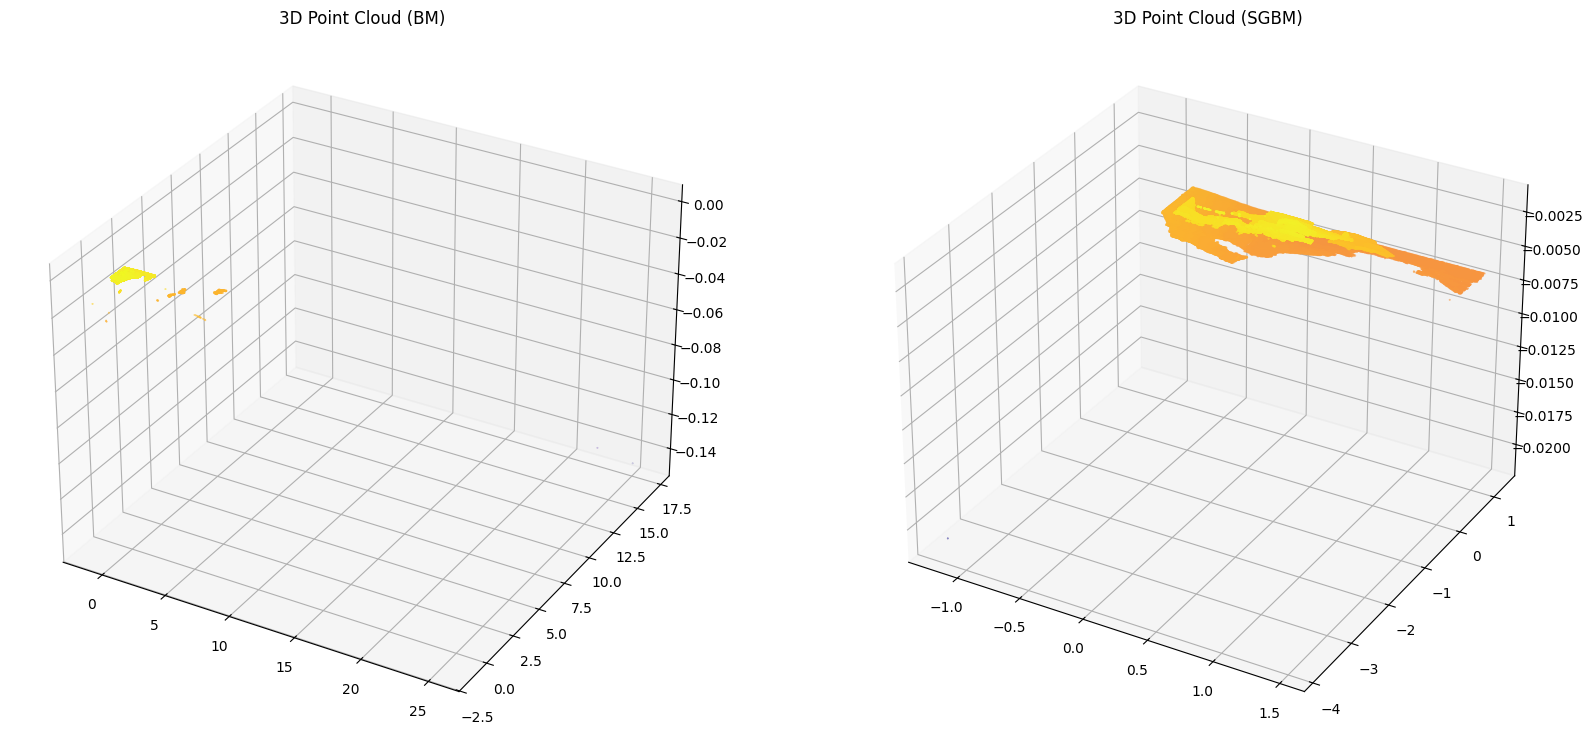

In [29]:
# Compute 3D point clouds for BM and SGBM disparity maps
def save_point_cloud(disparity, output_path):
    points_3D = cv2.reprojectImageTo3D(disparity, Q)
    mask = disparity > disparity.min()
    points_3D = points_3D[mask]
    with open(output_path, 'w') as f:
        f.write('ply\n')
        f.write('format ascii 1.0\n')
        f.write(f'element vertex {points_3D.shape[0]}\n')
        f.write('property float x\n')
        f.write('property float y\n')
        f.write('property float z\n')
        f.write('end_header\n')
        for point in points_3D:
            f.write(f'{point[0]} {point[1]} {point[2]}\n')

# Save point cloud for BM disparity map
output_point_cloud_bm_path = 'output/point_cloud_bm.ply'
save_point_cloud(disparity_bm, output_point_cloud_bm_path)
print(f'3D point cloud (BM) saved to {output_point_cloud_bm_path}')

# Save point cloud for SGBM disparity map
output_point_cloud_sgbm_path = 'output/point_cloud_sgbm.ply'
save_point_cloud(disparity_sgbm, output_point_cloud_sgbm_path)
print(f'3D point cloud (SGBM) saved to {output_point_cloud_sgbm_path}')

# Visualize and save 3D point clouds for BM and SGBM disparity maps
fig = plt.figure(figsize=(20, 10))

# BM point cloud
ax1 = fig.add_subplot(121, projection='3d')
points_3D_bm = cv2.reprojectImageTo3D(disparity_bm, Q)
mask_bm = disparity_bm > disparity_bm.min()
points_3D_bm = points_3D_bm[mask_bm]
ax1.scatter(points_3D_bm[:, 0], points_3D_bm[:, 1], points_3D_bm[:, 2], s=0.1, c=points_3D_bm[:, 2], cmap='plasma')
ax1.set_title('3D Point Cloud (BM)')

# SGBM point cloud
ax2 = fig.add_subplot(122, projection='3d')
points_3D_sgbm = cv2.reprojectImageTo3D(disparity_sgbm, Q)
mask_sgbm = disparity_sgbm > disparity_sgbm.min()
points_3D_sgbm = points_3D_sgbm[mask_sgbm]
ax2.scatter(points_3D_sgbm[:, 0], points_3D_sgbm[:, 1], points_3D_sgbm[:, 2], s=0.1, c=points_3D_sgbm[:, 2], cmap='plasma')
ax2.set_title('3D Point Cloud (SGBM)')

# Save visualization as PNG
output_point_cloud_visualization_path = 'output/point_cloud_visualization.png'
plt.savefig(output_point_cloud_visualization_path)
print(f'3D point cloud visualization saved to {output_point_cloud_visualization_path}')

plt.show()

## Bước 5: Ước lượng Ma trận Cơ sở và Vẽ các Đường Epipolar
Ước lượng ma trận cơ sở sử dụng các điểm tương ứng và vẽ các đường epipolar trên các hình ảnh đầu vào.

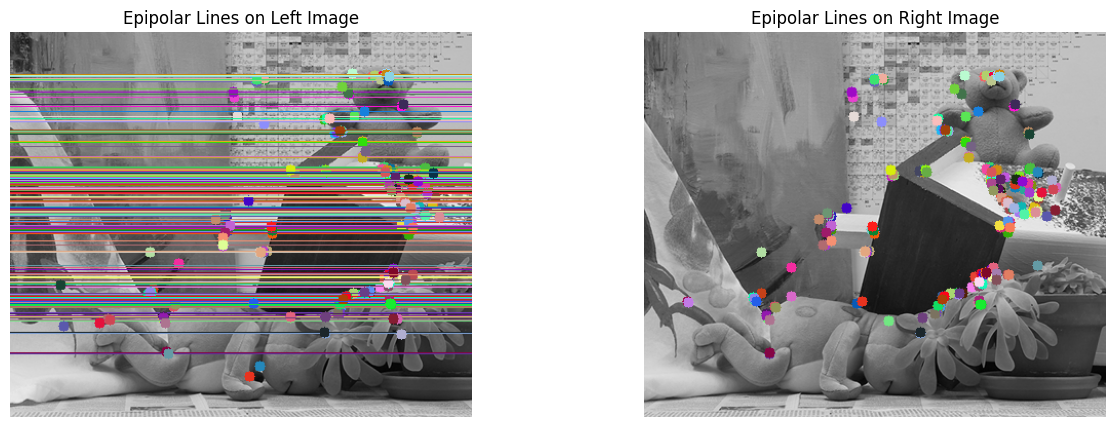

Epipolar lines saved to output/epipolar_lines_left.png and output/epipolar_lines_right.png


In [30]:
# Detect keypoints and match features
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(left_image, None)
kp2, des2 = orb.detectAndCompute(right_image, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)

# Extract matched points
pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

# Estimate fundamental matrix
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

# Draw epipolar lines
def draw_epipolar_lines(img1, img2, lines, pts1, pts2):
    img1_color = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2_color = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2] / r[1]])
        x1, y1 = map(int, [img1.shape[1], -(r[2] + r[0] * img1.shape[1]) / r[1]])
        img1_color = cv2.line(img1_color, (x0, y0), (x1, y1), color, 1)
        img1_color = cv2.circle(img1_color, tuple(map(int, pt1)), 5, color, -1)
        img2_color = cv2.circle(img2_color, tuple(map(int, pt2)), 5, color, -1)
    return img1_color, img2_color

lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F).reshape(-1, 3)
img1_epilines, img2_epilines = draw_epipolar_lines(left_image, right_image, lines1, pts1, pts2)

# Display images with epipolar lines
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(img1_epilines)
plt.title('Epipolar Lines on Left Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img2_epilines)
plt.title('Epipolar Lines on Right Image')
plt.axis('off')
plt.show()

# Save epipolar line images to output directory
output_left_path = 'output/epipolar_lines_left.png'
output_right_path = 'output/epipolar_lines_right.png'
cv2.imwrite(output_left_path, cv2.cvtColor(img1_epilines, cv2.COLOR_RGB2BGR))
cv2.imwrite(output_right_path, cv2.cvtColor(img2_epilines, cv2.COLOR_RGB2BGR))
print(f'Epipolar lines saved to {output_left_path} and {output_right_path}')

## Bước 6: So sánh BM và SGBM
Chúng ta sẽ so sánh hai phương pháp BM và SGBM dựa trên số lượng điểm hợp lệ, độ mượt mà và các hiện tượng nhiễu.

In [36]:
import time
from skimage.metrics import peak_signal_noise_ratio as psnr

# Bắt đầu đo thời gian
start_time = time.time()

# Tính toán và in ra số lượng điểm hợp lệ
valid_points_bm = np.sum(mask_bm)
valid_points_sgbm = np.sum(mask_sgbm)
print(f'Số điểm hợp lệ (BM): {valid_points_bm}')
print(f'Số điểm hợp lệ (SGBM): {valid_points_sgbm}')

# Tính toán PSNR cho các bản đồ độ chênh lệch
psnr_bm = psnr(disparity_bm, disparity_sgbm, data_range=disparity_sgbm.max() - disparity_sgbm.min())
print(f'PSNR giữa bản đồ độ chênh lệch BM và SGBM: {psnr_bm:.2f} dB')

# Kết thúc đo thời gian và in ra thời gian chạy
end_time = time.time()
runtime = end_time - start_time
print(f'Thời gian chạy: {runtime:.2f} giây')

Số điểm hợp lệ (BM): 112566
Số điểm hợp lệ (SGBM): 132372
PSNR giữa bản đồ độ chênh lệch BM và SGBM: 13.38 dB
Thời gian chạy: 0.00 giây
